## Stochastic Downscaling of Precipitation using Random Forests
### Worked Example using RandomForest2 package

#### Mikel N. Legasa, Rodrigo Manzanas and José Manuel Gutiérrez.

This is the companion notebook for the R package [**RandomForest2**](https://github.com/MNLR/RandomForest2), created with the purpose of extending random forests to accomodate for more split functions and estimation approaches. The package requires a modified version of [**rpart**](https://cran.r-project.org/web/packages/rpart/index.html) that can be found [here](https://github.com/MNLR/rpart). We briefly explain how to use the package by means of several examples.

This examples present the R code to reproduce the random forest models for the paper *Stochastic Downscaling of Precipitation using Random Forests*, submited to ---, in which we apply random forests to the problem of statistical downscaling of rainfall. We briefly explain how to build the models presented in the paper and use them to predict and generate new precipitation series.

The reader can install both packages from Github by means of the package `devtools`, executing

In [ ]:
devtools::install_github("MNLR/rpart")
install.packages(c("progressr", "qmap", "fitdistrplus"))
devtools::install_github("MNLR/RandomForest2")

We load `RandomForest2` and the example dataset included, `VALUE9`. This dataset contains rainfall series for 9 meteorological stations over Europe, along with their corresponding 17 large scale reanalysis predictors at the 4 nearest grid points. It corresponds to the subset of 9 meteorological stations described in the article *Stochastic Downscaling of Precipitation using Random Forests* (check the article for more information on the dataset). We use this dataset to describe the functionality of the package.

In [1]:
library(RandomForest2)
data(VALUE9)

Loading required package: rpart

Loading required package: progressr



It is a list of 9 elements, each one corresponding to a meteorological station. The data for each station is already divided into a stratified 5-fold (each fold comprises the years F1 = 1979−1984, F2 = 1985−1990, F3 = 1991-1996, F4 = 1997-2002, F5 = 2003-2008).  `$train.y` and `$test.y` correspond to the predictands; and `$train.x` and `$test.x` are the predictors. For example:

In [2]:
head(cbind(VALUE9[[1]]$f1_79_84$train.y, VALUE9[[1]]$f1_79_84$train.x))

5.4,100934.56,101076.31,101029.38,101127.6,0.9725891,-0.5552429,3.362726,1.4769836,53970.78,⋯,0.0008774727,0.0007474154,0.001837683,0.001404357,0.002788675,0.002296162,0.003939099,0.003326243,0.004503078,0.004167265
3.0,99861.81,100098.66,99890.75,100026.2,4.0751587,2.3417603,6.654260,4.7987915,53126.36,⋯,0.0007746874,0.0008232652,0.002964854,0.003158688,0.002753138,0.002897739,0.004851500,0.004605810,0.004810254,0.004700223
5.0,100774.52,101000.39,101343.70,101556.2,1.7720581,0.8526245,3.237878,0.7207886,53762.79,⋯,0.0008526679,0.0009968218,0.002528636,0.002547173,0.002720682,0.002845912,0.004383934,0.003969920,0.004411114,0.003889335
12.9,100790.47,100810.84,101059.16,101159.5,4.7946411,4.9987427,7.108118,5.1798950,54141.42,⋯,0.0013121588,0.0011717600,0.002218187,0.002100289,0.002669751,0.002809047,0.004955770,0.004400434,0.005563976,0.005303564
11.0,99843.41,99968.94,100306.59,100510.2,8.2443481,8.8000122,9.919641,7.6437622,53829.54,⋯,0.0012456127,0.0012676665,0.003520003,0.003533235,0.004003754,0.004093757,0.006390568,0.006163236,0.006739852,0.006437775
1.0,99936.30,99915.36,100108.30,100281.5,7.5472656,9.0443359,10.253320,8.7977539,53769.01,⋯,0.0014264237,0.0015940617,0.003558955,0.004082522,0.003949782,0.004051825,0.005973617,0.006448189,0.006836812,0.006869952


### Training the models
We select the sixth station and first fold to illustrate the training process.

In [3]:
train.x <- VALUE9[[6]]$f1_79_84$train.x
train.y <- VALUE9[[6]]$f1_79_84$train.y

The function `randomForestTrain()` builds the model for the predictors `x` and predictands `y`.

In [4]:
rf <- randomForestTrain(x = train.x, y = train.y)

We can specify the parameters `mtry`, the number of predictors to randomly use as candidate split variables; `ntree`, the number of trees in the model; `minbucket`, the minimum number of elements each leaf is required to have; `minsplit`, the minimum number of elements each node is required to have to attempt split; and `maxdepth`, the maximum allowed depth for each tree.

In [5]:
rf <- randomForestTrain(x = train.x, y = train.y, ntree = 25, mtry = 22, 
                        minbucket = 10, minsplit = 30, maxdepth = 10)

By default the models use root mean squared error as split function. The parameter `split.function` allows different split functions, as defined in the modified version of `rpart`. Currently supported options are `"anova", "poisson", "class", "exp", "gammaLLMME", "gammaLLmean", "bernoulliGammaLLMME", "gammaDeviation", "gammaLLBC3", "bernoulliLL"`. 

In this work we restrict ourselves to the gamma 2 parameter distribution family.

In [6]:
rf.dev <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, method = "gammaDeviation")
rf.LLMME <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, method = "gammaLLMME")
rf.LLBC3 <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, method = "gammaLLBC3")

### Parallelization

The training process can be parallelized by means of the package `future.apply`. The package has to be installed independently, otherwise parallelization will not be an option. Use `install.packages(future.apply)` to install it. This will also install the dependency `future`.

The simplest way to use parallelization is setting `parallel.plan = "auto"`. This will automatically use all the available cores to train the model in parallel.

In [7]:
rf <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10,
                        method = "gammaDeviation",
                        parallel.plan = "auto")

If not set to `"auto"`, the parameter `paralell.plan` corresponds to the execution plan corresponding to the `strategy` parameter in `future::plan()`. Refer to the packages `future` and `future.apply` for the available options. As an example, we show how parallelization in 4 cores can be achieved in combination with the parameter `workers` and setting the `parallel.plan` to `multisession`:

In [8]:
rf <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, 
                        method = "gammaDeviation", 
                        parallel.plan = future::multisession, workers = 4)

 Also, if left missing or set to `NULL` (default), the function will use the current plan. This is useful for configuration of the plan outside the function, as we do in the next example. We set the execution to `multisession()` prior to launching the loop and train several models using this plan (do not forget to close the sessions by reverting to `sequential()`).

In [9]:
future::plan(future::multisession, workers = 4)

rfs <- lapply(VALUE9[[1]], function(fold){
    return(
        randomForestTrain(x = fold$train.x, y = fold$train.y, ntree = 25, minbucket = 10, 
                          method = "gammaDeviation",
                          parallel.plan = NULL)
    )
    
})

future::plan(future::sequential)

Note that using `parallel.plan = NA` will avoid parallelization altogether. This is the default if `future.apply` is not available.

### Predictions and Simulations

Predictions can be obtained using the function `randomForestPredict()`. We use the out-of-sample predictors for the models above.

In [10]:
test.x <- VALUE9[[6]]$f1_79_84$test.x
test.y <- VALUE9[[6]]$f1_79_84$test.y

The default configuration uses bagging:

In [11]:
pr <- randomForestPredict(rf, newdata = test.x)
head(pr)

1        2        3        4        5        6 
5.990675 2.877779 4.354570 2.235861 3.743593 9.596656

The parameter `bagging.function` can be used to use other aggregation functions. Also, if set to `NA` the model outputs all the trees' predictions

In [12]:
pr.median <- randomForestPredict(rf, newdata = test.x, bagging.function = median)
pr.alltrees <- randomForestPredict(rf, newdata = test.x, bagging.function = NA)
pr.alltrees[1:10,] # Show the output of all the trees for the first 10 days

1,28.200000,7.4823529,3.561111,18.7100000,6.622222,5.7600000,13.550000,1.7769231,4.420000,6.760000,⋯,5.763158,6.270000,6.3923077,2.8812500,3.1153846,2.978947,19.366667,1.761111,6.1266667,4.2368421
2,0.990000,0.7400000,5.480000,5.5769231,2.440000,1.9400000,1.994737,0.7000000,1.681818,1.818182,⋯,5.763158,1.858824,0.9727273,0.7789474,1.6416667,3.238889,2.445455,10.133333,4.7500000,2.6187500
3,4.346154,1.0692308,5.480000,5.5769231,2.440000,1.0500000,13.590000,2.4142857,4.420000,4.326667,⋯,5.763158,5.254545,3.6000000,0.7789474,3.1153846,5.785714,3.535714,10.133333,2.0600000,7.4357143
4,1.450000,0.7400000,1.436364,0.5789474,2.440000,1.0500000,1.064706,1.7769231,1.000000,8.725000,⋯,5.763158,5.254545,2.2846154,0.6066667,0.4157895,2.978947,7.011765,1.761111,0.5181818,4.7000000
5,10.116667,1.6700000,3.561111,6.4266667,1.063636,0.9428571,11.710000,0.4466667,5.517647,1.463158,⋯,3.358333,6.723077,11.4555556,5.9300000,1.9800000,2.269231,2.563636,7.589474,3.6500000,0.9153846
6,5.066667,13.6562500,1.607143,7.8363636,11.480000,13.1454545,6.525000,4.5388889,32.305556,4.446154,⋯,5.170588,5.900000,5.3727273,6.8100000,2.5200000,12.823077,6.864286,10.850000,9.1647059,8.1769231
7,16.886667,3.3916667,6.630000,9.0833333,10.600000,6.3000000,4.670588,14.2250000,5.506250,8.945455,⋯,2.190000,7.870000,22.6700000,4.9230769,5.0294118,11.028571,1.625000,8.000000,5.4250000,7.4600000
8,2.500000,0.7058824,1.150000,8.8272727,4.590000,4.2235294,6.146154,8.4500000,1.681818,4.676923,⋯,3.236364,6.108333,4.4157895,1.3818182,7.1181818,4.769231,1.590000,2.520000,1.9470588,5.3818182
9,6.933333,7.1900000,11.773684,12.5000000,8.887500,8.9714286,12.669231,8.2545455,9.766667,10.916667,⋯,5.241667,13.900000,17.6250000,14.5900000,7.0454545,4.218182,8.800000,5.670000,3.6687500,8.4187500
10,10.136364,11.8363636,8.740000,11.5153846,18.060000,14.8166667,13.125000,15.4153846,9.529412,6.950000,⋯,12.247368,20.814286,10.5062500,11.1928571,17.4000000,5.545455,8.310526,6.872727,10.6100000,8.4187500


The parameter `method` controls the *a posteriori* approaches (described in the article). The options are described in the help page (`?randomForestPredict`), and we summarize them here. If `method` is not `NULL`, `bagging.function` is ignored.

- `method = "leaves"` outputs all the observations for each predictor. 
- `method = "random.sample"` draws a random sample from the leaves for each predictor. This approach is non-generative.
- `method = "aposteriori"` returns the parameter of the probability distribution of `train.y | train.x`, as estimated using Moments Matching Estimation (refer to `fitdistrplus::fitdist()`). In the case of the gamma distribution, this outputs the shape and rate of the distribution.
- Additionally, this parameter can be used to select the estimation method for fitdistrplus::fitdist(), i.e. one of the following: `"mle"` for Maximum Likelihood Estimation; `"mme"` for Moments Matching Estimation (same as `"aposteriori"`); `"qme"` for Quantile Matching Estimation; `"mge"` for Maximum Goodness-of-fit Estimation; "`mse`" for Maximum Spacing Estimation. Note that some of these options require additional parameters (use `...`), and that some of them may not converge.

We provide some examples below.

Predicting the leaves observations allows us to plot `train.y | train.x`. We do this for two values:

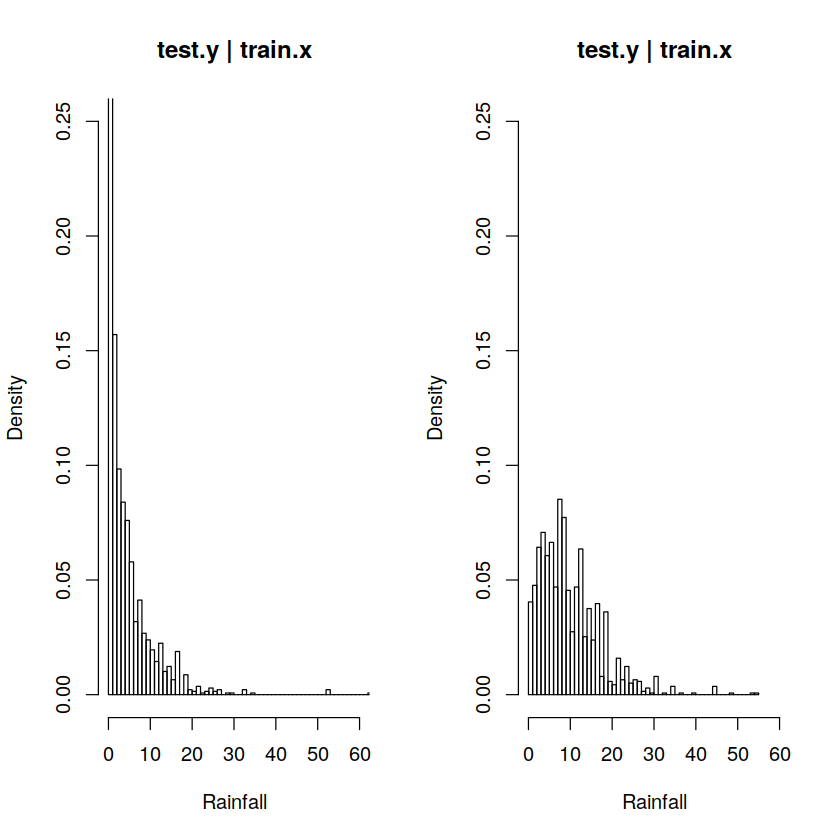

In [13]:
pr.leaves <- randomForestPredict(rf, newdata = test.x, method = "leaves")

par(mfrow = c(1,2))
hist(pr.leaves[[100]], breaks = 50, xlab = "Rainfall", freq = FALSE,
     main = "test.y | train.x", ylim = c(0, 0.25), xlim = c(0,60))
hist(pr.leaves[[300]], breaks = 50, xlab = "Rainfall", freq = FALSE, 
     main = "test.y | train.x",ylim = c(0, 0.25), xlim = c(0,60))

As the model was trained using the deviation for the two-parameter gamma distribution, using `method = "aposteriori"` outputs the two parameter for each prediction:

In [14]:
pr.distr <- randomForestPredict(rf, newdata = test.x, method = "aposteriori")
pr.distr[1:10,] # We show the first 10 days

shape,rate
0.6631633,0.1139398
0.8268574,0.2863083
1.3305145,0.3068724
0.7090563,0.3123169
1.0520843,0.2755289
1.1618595,0.1227533
1.5472187,0.1829556
1.0002698,0.2409027
2.5591922,0.2631880
4.3655413,0.3587182


As stated above, we can also directly input the method to `fitdistrplus::fitdist()`. For instance, we use maximum likelihood estimation with `method = "mle"`:

In [15]:
pr.mle <- randomForestPredict(rf, newdata = test.x, method = "mle")
pr.distr[1:10,] # Show the predicted distribution for the first 10 days

shape,rate
0.6631633,0.1139398
0.8268574,0.2863083
1.3305145,0.3068724
0.7090563,0.3123169
1.0520843,0.2755289
1.1618595,0.1227533
1.5472187,0.1829556
1.0002698,0.2409027
2.5591922,0.2631880
4.3655413,0.3587182


Finally, we can use the predicted distribution parameters to simulate series. We can do this using the function `randomForestSimulate()`. It takes a prediction object `prediction`, as output by `randomForestPredict()`; and the number of simulated series, `n`. The parameter `distr` allows for manually selecting the distribution, although the distribution will be automatically selected depending on the training split function.

In [16]:
simulation <- randomForestSimulate(pr.distr)

We simulate 1000 series:

In [17]:
simulations <- randomForestSimulate(pr.distr, n = 1000)
head(simulations)

16.401212,6.5780394,24.343978,4.3412076,0.07139387,3.6298965,0.4185125,3.363125973,0.2139395,0.005142123,⋯,0.9346878,5.705862,11.388554,4.5430340,4.8419281,0.06258068,3.1084244,7.9085157,5.4060905,9.9245108
1.824670,3.7815555,2.084874,3.3502654,1.18413629,5.5643711,5.2767448,0.001689017,1.8713019,0.272114207,⋯,0.5658543,0.269166,2.132391,0.7793248,1.1089032,0.90537817,0.9458167,0.9338746,0.7240090,0.7232405
3.427660,2.6542311,3.191854,0.7604726,2.67361941,1.2311706,0.7198240,1.637002697,0.6421465,1.613908754,⋯,3.2865840,11.630846,7.312694,3.2385869,6.3071792,3.53707248,0.7251712,6.4136084,4.5818876,7.0369741
19.928436,1.0209804,5.252162,1.1224609,0.53436078,0.6001669,2.5990611,3.045652762,1.8947598,1.772928534,⋯,0.1276340,2.722498,1.866763,0.2010061,3.2361187,1.09231113,1.3175135,8.4307085,0.5967682,0.2733909
2.086507,0.6370393,1.705948,13.7368541,3.74952797,0.3958324,2.4469552,4.382129599,5.7181549,1.108579954,⋯,2.5364276,4.278047,6.086361,1.3562598,0.7429805,10.48820494,0.3652106,8.4044147,4.9165105,0.1591949
6.042927,7.3132642,18.009456,7.8590195,1.14625264,8.6012624,17.7699422,9.408703483,11.1084704,0.589946095,⋯,10.1754256,8.053134,1.154221,7.9929981,27.4465627,5.68099604,5.4941933,3.1568796,5.8866068,3.5142137


### Complete Example

Finally, we reproduce here the 5-Fold experiment described in the article *Stochastic Downscaling of Precipitation using Random Forests* for the set of 9 stations. We use a model with $25$ trees, minimum leaf size $5$ and Deviation as split function.

In [18]:
future::plan(future::multisession, workers = 6)

predictions <-
lapply(VALUE9, function(meteorological.station){
    predictions <- lapply(meteorological.station, function(fold){
        md <- randomForestTrain(x = fold$train.x, y = fold$train.y, 
                                ntree = 25, minbucket = 5, 
                                method = "gammaDeviation",
                                parallel.plan = NULL)
        
        return( list(predicted = randomForestPredict(md, newdata = fold$test.x, method = "mme"),
                     observed = fold$test.y)
              )
    })
    
    predicted <- do.call(rbind, lapply(predictions, function(pr) pr$predicted))
    observed <- do.call(c, lapply(predictions, function(pr) pr$observed))

    return( list(predicted = predicted, observed = observed) )
})

future::plan(future::sequential)

We end up with the downscaled probability distribution for each station and day.